In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from scipy import stats
from joblib import dump

# Step 1: Load the Dataset
file_path = '/content/train.csv'
df = pd.read_csv(file_path)

print("Dataset Loaded Successfully.")
print("Dataset Shape:", df.shape)
print(df.head())

# Step 2: Basic Preprocessing
print("\n--- Basic Preprocessing ---")

# 2.1 Check for Missing Values
print("Missing Values in Each Column:")
missing_values = df.isnull().sum()
print(missing_values)

# Drop rows with excessive missing data (optional threshold: 30%)
missing_threshold = 0.3 * df.shape[0]
df = df.drop(columns=[col for col in df.columns if df[col].isnull().sum() > missing_threshold])

# Drop remaining rows with missing values
df.dropna(inplace=True)
print(f"Shape after handling missing values: {df.shape}")

# 2.2 Remove Outliers using Z-score
print("\nRemoving Outliers using Z-Score...")

# Select only numeric columns for Z-score calculation
numeric_cols = df.select_dtypes(include=[np.number]).columns
if 'id' in numeric_cols:
    numeric_cols = numeric_cols.drop('id')  # Exclude 'id' column if present

# Calculate Z-scores and remove outliers
threshold = 3
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df = df[(z_scores < threshold).all(axis=1)]

print(f"Shape after removing outliers: {df.shape}")

# Step 3: Encoding Categorical Columns
print("\nEncoding Categorical Columns...")

# Identify categorical columns and apply encoding
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Shape after encoding categorical columns: {df.shape}")

# Step 4: SelectKBest before Feature Scaling
print("\nApplying SelectKBest Before Scaling...")

# Define features (X) and target (y)
if 'id' in df.columns:
    X = df.drop(columns=['TenYearCHD', 'id'])  # Drop 'TenYearCHD' (target) and 'id' (identifier)
else:
    X = df.drop(columns=['TenYearCHD'])
y = df['TenYearCHD']

# Apply SelectKBest to select top K features based on f_classif
k = 6
selector = SelectKBest(f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_columns = X.columns[selector.get_support()]
print(f"Selected Features: {selected_columns.tolist()}")

# Convert selected features back to a DataFrame for compatibility
# X_selected = pd.DataFrame(X_selected, columns=selected_columns)

# Step 5: Apply SMOTE-ENN
print("\n--- Applying SMOTE-ENN for Balancing ---")

# Apply SMOTE-ENN for balancing the dataset
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_selected, y)

# Verify resampled dataset shapes
print("SMOTE-ENN Applied. Resampled Dataset Shape:", X_resampled.shape)
print("Resampled Target Shape:", y_resampled.shape)

# Step 6: Train-Test Split (80-20)
print("\n--- Splitting the Dataset into Train and Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

# Save processed datasets if required
dump(X_train, 'X_train.joblib')
dump(X_test, 'X_test.joblib')
dump(y_train, 'y_train.joblib')
dump(y_test, 'y_test.joblib')

print("\nPreprocessing, SelectKBest, SMOTE-ENN, and Train-Test Split Complete.")


Dataset Loaded Successfully.
Dataset Shape: (3390, 17)
   id  age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
0   0   64        2.0   F        YES         3.0     0.0                0   
1   1   36        4.0   M         NO         0.0     0.0                0   
2   2   46        1.0   F        YES        10.0     0.0                0   
3   3   50        1.0   M        YES        20.0     0.0                0   
4   4   64        1.0   F        YES        30.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    221.0  148.0   85.0    NaN       90.0     80.0   
1             1         0    212.0  168.0   98.0  29.77       72.0     75.0   
2             0         0    250.0  116.0   71.0  20.35       88.0     94.0   
3             1         0    233.0  158.0   88.0  28.26       68.0     94.0   
4             0         0    241.0  136.5   85.0  26.42       70.0     77.0   

   TenY

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [3 4 6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pandas as pd

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and Evaluate Models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Save Results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    # Print Metrics
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Feature Importance for Tree-Based Models
    if hasattr(model, 'feature_importances_'):
        # Get the boolean mask of selected features (from SelectKBest)
        selected_mask = selector.get_support()

        # Get the feature names (from the original X DataFrame)
        selected_feature_names = X.columns[selected_mask]

        # Retrieve feature importances
        importance = model.feature_importances_

        # Create a DataFrame to visualize the importances
        importance_df = pd.DataFrame(list(zip(selected_feature_names, importance)), columns=['Feature', 'Importance'])

        # Sort by importance value (descending)
        # importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Show important features
        print("\nFeature Importances:")
        print(importance_df)

# Summary of All Results
print("\n--- Summary of Model Results ---")
summary_df = pd.DataFrame(results).T
print(summary_df)



Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7749
Precision: 0.7792
Recall: 0.8650
F1 Score: 0.8198

Confusion Matrix:
[[161  89]
 [ 49 314]]

Training Random Forest...
Random Forest Results:
Accuracy: 0.9266
Precision: 0.9321
Recall: 0.9449
F1 Score: 0.9384

Confusion Matrix:
[[225  25]
 [ 20 343]]

Feature Importances:
        Feature  Importance
0           age    0.293523
1  prevalentHyp    0.047485
2       totChol    0.185052
3         sysBP    0.202899
4         diaBP    0.136844
5         sex_M    0.134197

Training SVM...
SVM Results:
Accuracy: 0.7716
Precision: 0.7726
Recall: 0.8705
F1 Score: 0.8187

Confusion Matrix:
[[157  93]
 [ 47 316]]

Training KNN...
KNN Results:
Accuracy: 0.9315
Precision: 0.9063
Recall: 0.9862
F1 Score: 0.9446

Confusion Matrix:
[[213  37]
 [  5 358]]

Training Gradient Boosting...
Gradient Boosting Results:
Accuracy: 0.8825
Precision: 0.8799
Recall: 0.9284
F1 Score: 0.9035

Confusion Matrix:
[[204  46]
 [ 26 337]]

Featur

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:05:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.9217
Precision: 0.9200
Recall: 0.9504
F1 Score: 0.9350

Confusion Matrix:
[[220  30]
 [ 18 345]]

Feature Importances:
        Feature  Importance
0           age    0.145995
1  prevalentHyp    0.171666
2       totChol    0.061587
3         sysBP    0.074758
4         diaBP    0.050386
5         sex_M    0.495608

--- Summary of Model Results ---
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.774878   0.779156  0.865014  0.819843
Random Forest        0.926591   0.932065  0.944904  0.938440
SVM                  0.771615   0.772616  0.870523  0.818653
KNN                  0.931485   0.906329  0.986226  0.944591
Gradient Boosting    0.882545   0.879896  0.928375  0.903485
XGBoost              0.921697   0.920000  0.950413  0.934959


In [25]:
df.head()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_M,is_smoking_YES
1,1,36,4.0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,True,False
2,2,46,1.0,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,False,True
3,3,50,1.0,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,True,True
4,4,64,1.0,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,False,True
7,7,36,4.0,35.0,0.0,0,0,0,295.0,102.0,68.0,28.15,60.0,63.0,0,True,True


In [20]:
import joblib

# After training the model
print("\nTraining Random Forest...")
random_forest_model = models["Random Forest"]
random_forest_model.fit(X_train, y_train)

# Save the Random Forest model using joblib
joblib.dump(random_forest_model, 'random_forest.joblib')
print("Random Forest model saved successfully.")



Training Random Forest...
Random Forest model saved successfully.


In [ ]:
# Load the saved XGBoost model
loaded_xgboost_model = joblib.load('xgboost_model.joblib')


In [ ]:
# Check the column names/features used in the training dataset
print(X_train.columns)


Index(['age', 'sex', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP'], dtype='object')


In [ ]:
X_train.head()

,age,sex,prevalentHyp,totChol,sysBP,diaBP
678,0.702703,0.0,1.0,0.463035,0.532468,0.647887
2206,0.837838,0.0,0.0,0.440380,0.460749,0.278750
1729,0.862293,0.0,1.0,0.559934,0.597612,0.380282
2204,0.575868,0.0,0.0,0.711494,0.369976,0.566651
2849,0.320160,1.0,0.0,0.519385,0.415172,0.450704


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/train.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and general information
data_info = {
    "head": data.head(),
    "info": data.info(),
    "missing_values": data.isnull().sum(),
    "description": data.describe(include='all')
}
data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

{'head':    id  age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
 0   0   64        2.0   F        YES         3.0     0.0                0   
 1   1   36        4.0   M         NO         0.0     0.0                0   
 2   2   46        1.0   F        YES        10.0     0.0                0   
 3   3   50        1.0   M        YES        20.0     0.0                0   
 4   4   64        1.0   F        YES        30.0     0.0                0   
 
    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
 0             0         0    221.0  148.0   85.0    NaN       90.0     80.0   
 1             1         0    212.0  168.0   98.0  29.77       72.0     75.0   
 2             0         0    250.0  116.0   71.0  20.35       88.0     94.0   
 3             1         0    233.0  158.0   88.0  28.26       68.0     94.0   
 4             0         0    241.0  136.5   85.0  26.42       70.0     77.0   
 
    TenYearCHD  
 0           1  
 1    

In [ ]:
from sklearn.impute import SimpleImputer

# Separate categorical and numerical columns
categorical_cols = ['sex', 'is_smoking']
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop('TenYearCHD')

# Impute missing numerical values with mean
num_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])

# Impute missing categorical values with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

# Check for remaining missing values
missing_after_imputation = data.isnull().sum()
missing_after_imputation


,0
id,0
age,0
education,0
sex,0
is_smoking,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0


In [ ]:
# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Display the updated columns after encoding
encoded_columns = data_encoded.columns
encoded_columns


Index(['id', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentStroke',
       'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI',
       'heartRate', 'glucose', 'TenYearCHD', 'sex_M', 'is_smoking_YES'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming you have the full dataset with all 16 features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_encoded[features_to_scale])  # features_to_scale should now include all 16 features

# Save the trained scaler
joblib.dump(scaler, 'minmax_scaler.pkl')


['minmax_scaler.pkl']

In [ ]:
# Handle missing values
# Impute missing numerical data with mean
num_imputer = SimpleImputer(strategy='mean')
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop('TenYearCHD')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])

# Impute missing categorical data with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = ['sex', 'is_smoking']
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

# Check for remaining missing values
missing_values_after_step1 = data.isnull().sum()
missing_values_after_step1


,0
id,0
age,0
education,0
sex,0
is_smoking,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0


In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
missing_data = df.isna().sum()
print(missing_data)

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64


In [ ]:
import math
import pandas as pd

# Example DataFrame (assuming `df` is already loaded with your data)
# columns_with_missing_data is a list of columns you want to process for missing values
columns_with_missing_data = ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

# Loop through each column with missing data and calculate the mean values
for column in columns_with_missing_data:
    # Calculate the mean value of the feature
    mean_value = df[column].mean()
    print(f"{column} - Mean Value (All):", round(mean_value, 1), math.ceil(mean_value))

    # Calculate the mean value of the specified feature, excluding 0.0
    mean_value_exclude_zero = df[df[column] != 0.0][column].mean()
    print(f"{column} - Mean Value (Excluding 0):", round(mean_value_exclude_zero, 1), math.ceil(mean_value_exclude_zero))

    # Calculate the mean value of the specified feature, excluding 0.0 and NaN
    mean_value_exclude_zero_nan = df[(df[column] != 0.0) & (~df[column].isna())][column].mean()
    print(f"{column} - Mean Value (Excluding 0 & NaN):", round(mean_value_exclude_zero_nan, 1), math.ceil(mean_value_exclude_zero_nan))

    # Fill missing values with the mean calculated excluding 0 and NaN
    df[column] = df[column].fillna(mean_value_exclude_zero_nan)

# Display updated missing values
missing_data_after = df.isna().sum()
print("\nMissing data after filling:")
print(missing_data_after)


education - Mean Value (All): 2.0 2
education - Mean Value (Excluding 0): 2.0 2
education - Mean Value (Excluding 0 & NaN): 2.0 2
cigsPerDay - Mean Value (All): 9.1 10
cigsPerDay - Mean Value (Excluding 0): 18.3 19
cigsPerDay - Mean Value (Excluding 0 & NaN): 18.3 19
BPMeds - Mean Value (All): 0.0 1
BPMeds - Mean Value (Excluding 0): 1.0 1
BPMeds - Mean Value (Excluding 0 & NaN): 1.0 1
totChol - Mean Value (All): 237.1 238
totChol - Mean Value (Excluding 0): 237.1 238
totChol - Mean Value (Excluding 0 & NaN): 237.1 238
BMI - Mean Value (All): 25.8 26
BMI - Mean Value (Excluding 0): 25.8 26
BMI - Mean Value (Excluding 0 & NaN): 25.8 26
heartRate - Mean Value (All): 76.0 76
heartRate - Mean Value (Excluding 0): 76.0 76
heartRate - Mean Value (Excluding 0 & NaN): 76.0 76
glucose - Mean Value (All): 82.1 83
glucose - Mean Value (Excluding 0): 82.1 83
glucose - Mean Value (Excluding 0 & NaN): 82.1 83

Missing data after filling:
id                 0
age                0
education          0

In [ ]:
import math
import pandas as pd

# List of columns with missing or 0.0 values to process
columns_with_missing_data = ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

# Loop through each column with missing or 0.0 values
mean_values = {}

for column in columns_with_missing_data:
    # Calculate the mean value of the specified feature, excluding 0.0 and NaN
    mean_value_exclude_zero_nan = df[(df[column] != 0.0) & (~df[column].isna())][column].mean()
    mean_values[column] = mean_value_exclude_zero_nan

    # Print the mean and its ceiling for verification
    print(f"{column} - Mean Value (Excluding 0 & NaN):", round(mean_value_exclude_zero_nan, 1), math.ceil(mean_value_exclude_zero_nan))


education - Mean Value (Excluding 0 & NaN): 2.0 2
cigsPerDay - Mean Value (Excluding 0 & NaN): 18.3 19
BPMeds - Mean Value (Excluding 0 & NaN): 1.0 1
totChol - Mean Value (Excluding 0 & NaN): 237.1 238
BMI - Mean Value (Excluding 0 & NaN): 25.8 26
heartRate - Mean Value (Excluding 0 & NaN): 76.0 76
glucose - Mean Value (Excluding 0 & NaN): 82.1 83


In [ ]:
# Replace 0.0 values with the ceiling of the calculated mean
for column in columns_with_missing_data:
    # Use the calculated mean value from the previous cell
    mean_value_exclude_zero_nan = mean_values[column]

    # Replace 0.0 values with the ceiling of the calculated mean
    df.loc[df[column] == 0.0, column] = math.ceil(mean_value_exclude_zero_nan)

    # Print the update for verification
    print(f"Replaced 0.0 in {column} with {math.ceil(mean_value_exclude_zero_nan)}")


Replaced 0.0 in education with 2
Replaced 0.0 in cigsPerDay with 19
Replaced 0.0 in BPMeds with 1
Replaced 0.0 in totChol with 238
Replaced 0.0 in BMI with 26
Replaced 0.0 in heartRate with 76
Replaced 0.0 in glucose with 83


In [ ]:
# Display updated missing values
missing_data_after = df.isna().sum()
print("\nMissing data after filling:")
print(missing_data_after)



Missing data after filling:
id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


In [ ]:
df.head(10)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,1.0,0,0,0,221.0,148.0,85.0,25.794964,90.0,80.00000,1
1,1,36,4.0,M,NO,19.0,1.0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.00000,0
2,2,46,1.0,F,YES,10.0,1.0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.00000,0
3,3,50,1.0,M,YES,20.0,1.0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.00000,1
4,4,64,1.0,F,YES,30.0,1.0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.00000,0
5,5,61,3.0,F,NO,19.0,1.0,0,1,0,272.0,182.0,121.0,32.800000,85.0,65.00000,1
6,6,61,1.0,M,NO,19.0,1.0,0,1,0,238.0,232.0,136.0,24.830000,75.0,79.00000,0
7,7,36,4.0,M,YES,35.0,1.0,0,0,0,295.0,102.0,68.0,28.150000,60.0,63.00000,0
8,8,41,2.0,F,YES,20.0,1.0,0,0,0,220.0,126.0,78.0,20.700000,86.0,79.00000,0
9,9,55,2.0,F,NO,19.0,1.0,0,1,0,326.0,144.0,81.0,25.710000,85.0,82.08652,0


In [ ]:
# Loop through each column to remove ".0" from the values
for column in columns_with_missing_data:
    # Remove ".0" from the column values
    df[column] = df[column].astype(str).str.rstrip('.0')

    # Print the updated column for verification (showing first 10 rows)
    print(f"Updated values in {column}:")
    print(df[column].head(10))


Updated values in education:
0    2
1    4
2    1
3    1
4    1
5    3
6    1
7    4
8    2
9    2
Name: education, dtype: object
Updated values in cigsPerDay:
0     3
1    19
2     1
3     2
4     3
5    19
6    19
7    35
8     2
9    19
Name: cigsPerDay, dtype: object
Updated values in BPMeds:
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: BPMeds, dtype: object
Updated values in totChol:
0    221
1    212
2     25
3    233
4    241
5    272
6    238
7    295
8     22
9    326
Name: totChol, dtype: object
Updated values in BMI:
0    25.794964454976306
1                 29.77
2                 20.35
3                 28.26
4                 26.42
5                  32.8
6                 24.83
7                 28.15
8                  20.7
9                 25.71
Name: BMI, dtype: object
Updated values in heartRate:
0     9
1    72
2    88
3    68
4     7
5    85
6    75
7     6
8    86
9    85
Name: heartRate, dtype: object
Updated values in glucose:
0  

In [ ]:
# Loop through each column to replace all values with 1, except for 0
for column in columns_with_missing_data:
    # Replace all values except for 0 with 1
    df.loc[df[column] != '0', column] = 1

    # Print the updated column for verification (showing first 10 rows)
    print(f"Updated values in {column} (Replaced non-zero values with 1):")
    print(df[column].head(10))


Updated values in education (Replaced non-zero values with 1):
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: education, dtype: object
Updated values in cigsPerDay (Replaced non-zero values with 1):
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: cigsPerDay, dtype: object
Updated values in BPMeds (Replaced non-zero values with 1):
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: BPMeds, dtype: object
Updated values in totChol (Replaced non-zero values with 1):
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: totChol, dtype: object
Updated values in BMI (Replaced non-zero values with 1):
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: BMI, dtype: object
Updated values in heartRate (Replaced non-zero values with 1):
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: heartRate, dtype: object
Updated values in glucose (Replaced 

In [ ]:
# Save the updated DataFrame back to a CSV file
df.to_csv('Cardiovascular_Preprocessed.csv',index=False)

In [ ]:
from google.colab import files


In [ ]:
# Download the file to your local PC
files.download('Cardiovascular_Preprocessed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/Cardiovascular_Preprocessed.csv')

In [ ]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,1,F,YES,1,1,0,0,0,1,148.0,85.0,1,1,1,1
1,1,36,1,M,NO,1,1,0,1,0,1,168.0,98.0,1,1,1,0
2,2,46,1,F,YES,1,1,0,0,0,1,116.0,71.0,1,1,1,0
3,3,50,1,M,YES,1,1,0,1,0,1,158.0,88.0,1,1,1,1
4,4,64,1,F,YES,1,1,0,0,0,1,136.5,85.0,1,1,1,0


In [ ]:
# Selecting features for unsupervised learning (excluding the target column 'TenYearCHD' and other non-numeric features)
features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['TenYearCHD', 'id'])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


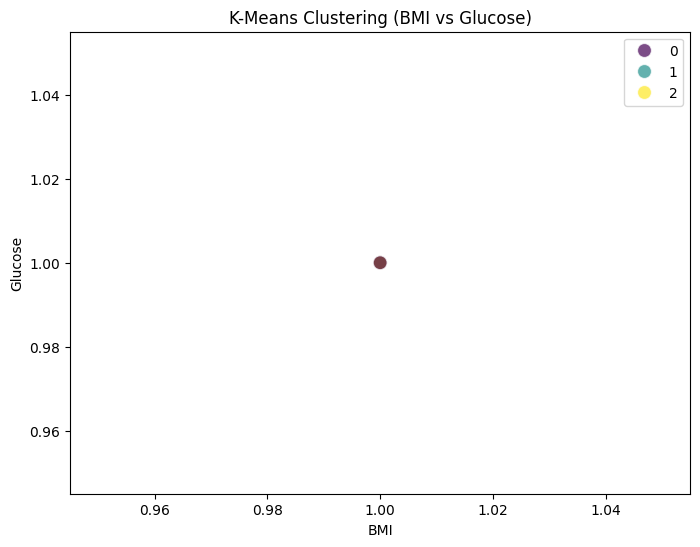

In [ ]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters (n_clusters)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Plotting the clustering result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['BMI'], y=df['glucose'], hue=df['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering (BMI vs Glucose)')
plt.xlabel('BMI')
plt.ylabel('Glucose')
plt.legend()
plt.show()


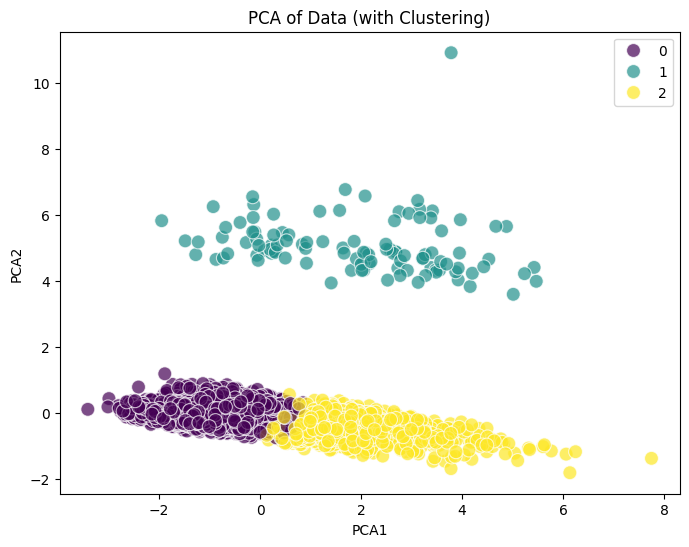

Variance explained by PCA1: 0.44
Variance explained by PCA2: 0.17


In [ ]:
# Apply PCA for dimensionality reduction (2 components)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Create a DataFrame for the PCA components
df_pca = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])

# Plot the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PCA1'], y=df_pca['PCA2'], hue=df['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Data (with Clustering)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Variance explained by each component
print(f"Variance explained by PCA1: {pca.explained_variance_ratio_[0]:.2f}")
print(f"Variance explained by PCA2: {pca.explained_variance_ratio_[1]:.2f}")


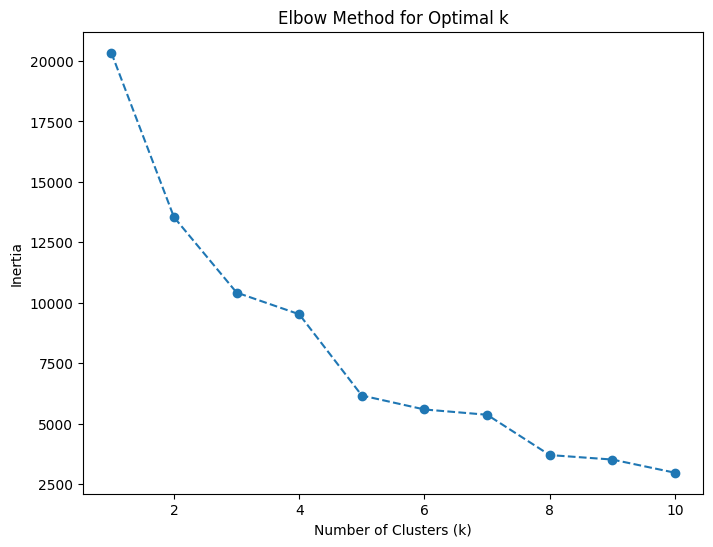

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, df['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')


Silhouette Score: 0.48


Cluster
0    2268
2    1014
1     108
Name: count, dtype: int64


<ipython-input-31-3add9ef8b7f4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Cluster'], palette='viridis')


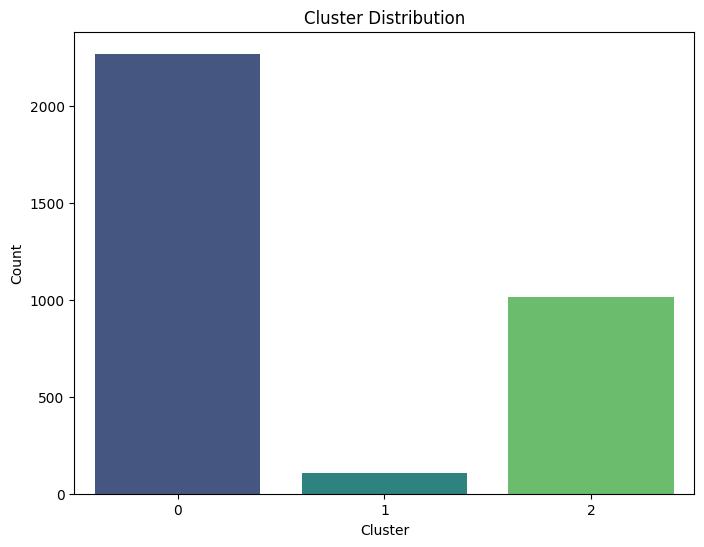

In [ ]:
cluster_counts = df['Cluster'].value_counts()
print(cluster_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x=df['Cluster'], palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [ ]:
cluster_means = df.groupby('Cluster')[['BMI', 'glucose', 'age']].mean()
print(cluster_means)


         BMI  glucose        age
Cluster                         
0        1.0      1.0  47.509700
1        1.0      1.0  55.342593
2        1.0      1.0  53.470414


In [ ]:
# Save the DataFrame with the cluster labels to a new CSV file
df.to_csv('Cardiovascular_with_Clusters.csv', index=False)


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [ ]:
# Assuming 'TenYearCHD' is the target variable
X = df.drop(columns=['TenYearCHD', 'id'])  # Drop target and non-numeric columns
y = df['TenYearCHD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Check which columns are categorical
categorical_columns = df.select_dtypes(include=['object']).columns

# Check for unique values in the categorical columns to decide encoding type
for column in categorical_columns:
    print(f"Unique values in {column}: {df[column].unique()}")


Unique values in sex: ['F' 'M']
Unique values in is_smoking: ['YES' 'NO']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns (e.g., sex, education, etc.)
# You can specify columns based on your inspection in the previous step
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Verify the changes
print(df.head())


   id  age  education  sex  is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
0   0   64          1    0           1           1       1                0   
1   1   36          1    1           0           1       1                0   
2   2   46          1    0           1           1       1                0   
3   3   50          1    1           1           1       1                0   
4   4   64          1    0           1           1       1                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP  BMI  heartRate  glucose  \
0             0         0        1  148.0   85.0    1          1        1   
1             1         0        1  168.0   98.0    1          1        1   
2             0         0        1  116.0   71.0    1          1        1   
3             1         0        1  158.0   88.0    1          1        1   
4             0         0        1  136.5   85.0    1          1        1   

   TenYearCHD  Cluster  
0           1        0  
1           

In [ ]:
# Apply One-Hot Encoding to nominal columns (e.g., 'is_smoking', 'BPMeds')
df = pd.get_dummies(df, drop_first=True)

# Verify the changes
print(df.head())


   id  age  education  sex  is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
0   0   64          1    0           1           1       1                0   
1   1   36          1    1           0           1       1                0   
2   2   46          1    0           1           1       1                0   
3   3   50          1    1           1           1       1                0   
4   4   64          1    0           1           1       1                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP  BMI  heartRate  glucose  \
0             0         0        1  148.0   85.0    1          1        1   
1             1         0        1  168.0   98.0    1          1        1   
2             0         0        1  116.0   71.0    1          1        1   
3             1         0        1  158.0   88.0    1          1        1   
4             0         0        1  136.5   85.0    1          1        1   

   TenYearCHD  Cluster  
0           1        0  
1           

In [ ]:
# Apply One-Hot Encoding to categorical columns (for nominal variables)
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Prepare the data
X = df.drop(columns=['TenYearCHD', 'id'])  # Drop target and non-numeric columns
y = df['TenYearCHD']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=10000, random_state=42)

# Apply RFE (Recursive Feature Elimination)
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_train, y_train)

# Get the selected features
selected_features_rfe = X_train.columns[rfe.support_]
print("Selected features using RFE:")
print(selected_features_rfe)


Selected features using RFE:
Index(['age', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'BMI',
       'heartRate', 'glucose', 'Cluster', 'sex_1', 'is_smoking_1'],
      dtype='object')


In [ ]:
# Create a new dataset with selected features (e.g., using the features from RFE)
X_train_selected = X_train[selected_features_rfe]
X_test_selected = X_test[selected_features_rfe]

# Print the new dataset
print("New training data with selected features:")
print(X_train_selected.head())


New training data with selected features:
      age  prevalentStroke  prevalentHyp  diabetes  BMI  heartRate  glucose  \
2378   66                0             1         0    1          1        1   
3182   53                0             1         0    1          1        1   
921    46                0             0         0    1          1        1   
2244   40                0             0         0    1          1        1   
3131   51                0             0         0    1          1        1   

      Cluster  sex_1  is_smoking_1  
2378        2  False         False  
3182        2  False         False  
921         0  False          True  
2244        0  False          True  
3131        0  False         False  


In [ ]:
# Save the new dataset with selected features
X_train_selected.to_csv('X_train_selected.csv', index=False)
X_test_selected.to_csv('X_test_selected.csv', index=False)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [ ]:
# Drop target column 'TenYearCHD' and 'id' columns, keep all other features
X = df.drop(columns=['TenYearCHD', 'id'])  # Features
y = df['TenYearCHD']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (optional but often improves performance for some models like SVM and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 1. Logistic Regression (Linear Model)
lr = LogisticRegression(max_iter=10000, random_state=42)

# 2. K-Nearest Neighbors (Non-linear Model)
knn = KNeighborsClassifier()

# 3. Support Vector Machine (SVM) (Non-linear Model)
svm = SVC(random_state=42)

# 4. Random Forest Classifier (Ensemble Model)
rf = RandomForestClassifier(random_state=42)

# 5. Gradient Boosting Classifier (Boosting Algorithm)
gb = GradientBoostingClassifier(random_state=42)


In [ ]:
# Train and evaluate each model

# Logistic Regression
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

# K-Nearest Neighbors
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
knn_acc = accuracy_score(y_test, knn_pred)
print(f"K-Nearest Neighbors Accuracy: {knn_acc:.4f}")

# Support Vector Machine
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"Support Vector Machine Accuracy: {svm_acc:.4f}")

# Random Forest Classifier
rf.fit(X_train, y_train)  # No need to scale for Random Forest
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# Gradient Boosting Classifier
gb.fit(X_train, y_train)  # No need to scale for Gradient Boosting
gb_pred = gb.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}")


Logistic Regression Accuracy: 0.8658
K-Nearest Neighbors Accuracy: 0.8540
Support Vector Machine Accuracy: 0.8569
Random Forest Accuracy: 0.8466
Gradient Boosting Accuracy: 0.8555


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print detailed performance for Gradient Boosting (as an example)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_pred))

print("\nConfusion Matrix for Gradient Boosting:")
print(confusion_matrix(y_test, gb_pred))



Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       581
           1       0.47      0.07      0.12        97

    accuracy                           0.86       678
   macro avg       0.67      0.53      0.52       678
weighted avg       0.81      0.86      0.81       678


Confusion Matrix for Gradient Boosting:
[[573   8]
 [ 90   7]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop target column 'TenYearCHD' and 'id', keep all other features
X = df.drop(columns=['TenYearCHD', 'id'])  # Features
y = df['TenYearCHD']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardize the data (optional for some models like SVM and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])),
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    if name in ["Random Forest", "Gradient Boosting", "XGBoost"]:  # These models don't need scaling
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test)
    else:  # Scaled data for Logistic Regression, KNN, and SVM
        model.fit(X_train_scaled, y_train_smote)
        y_pred = model.predict(X_test_scaled)

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



=== Logistic Regression ===
Accuracy: 0.7006
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       581
           1       0.24      0.49      0.32        97

    accuracy                           0.70       678
   macro avg       0.57      0.61      0.56       678
weighted avg       0.80      0.70      0.74       678

Confusion Matrix:
[[427 154]
 [ 49  48]]

=== K-Nearest Neighbors ===
Accuracy: 0.7021
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       581
           1       0.23      0.44      0.30        97

    accuracy                           0.70       678
   macro avg       0.56      0.59      0.55       678
weighted avg       0.79      0.70      0.74       678

Confusion Matrix:
[[433 148]
 [ 54  43]]

=== Support Vector Machine ===
Accuracy: 0.7035
Classification Report:
              precision    recall  f1-score   support


Accuracy after class weighting: 0.7684

Classification Report (with class weight):
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       581
           1       0.27      0.36      0.31        97

    accuracy                           0.77       678
   macro avg       0.58      0.60      0.58       678
weighted avg       0.80      0.77      0.78       678


Confusion Matrix (with class weight):
[[486  95]
 [ 62  35]]


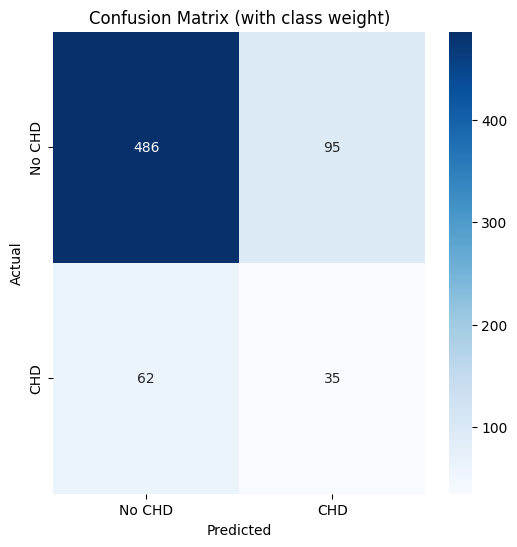

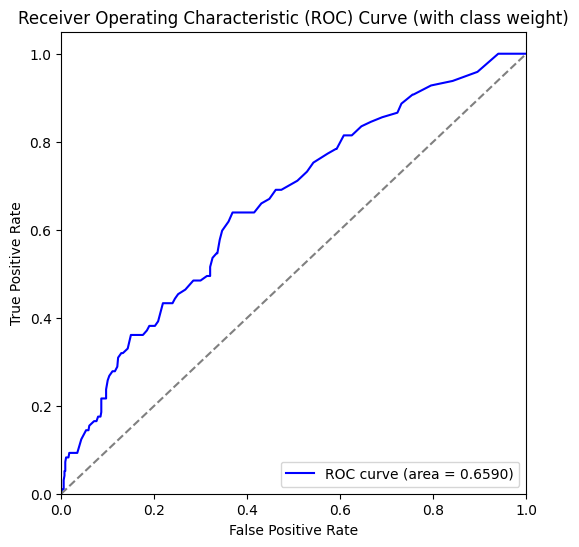


AUC Score (with class weight): 0.6590


In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize Random Forest with class weights to handle class imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model with the balanced class weights
rf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy after class weighting: {accuracy_rf:.4f}")

# Classification Report
print("\nClassification Report (with class weight):")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("\nConfusion Matrix (with class weight):")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

# Plotting confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["No CHD", "CHD"], yticklabels=["No CHD", "CHD"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (with class weight)')
plt.show()

# ROC Curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'ROC curve (area = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (with class weight)')
plt.legend(loc="lower right")
plt.show()

# AUC Score
print(f"\nAUC Score (with class weight): {roc_auc_rf:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
71 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py",

Best hyperparameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy after hyperparameter tuning: 0.7625

Classification Report (after hyperparameter tuning):
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       581
           1       0.26      0.35      0.30        97

    accuracy                           0.76       678
   macro avg       0.57      0.59      0.58       678
weighted avg       0.79      0.76      0.78       678


Confusion Matrix (after hyperparameter tuning):
[[483  98]
 [ 63  34]]


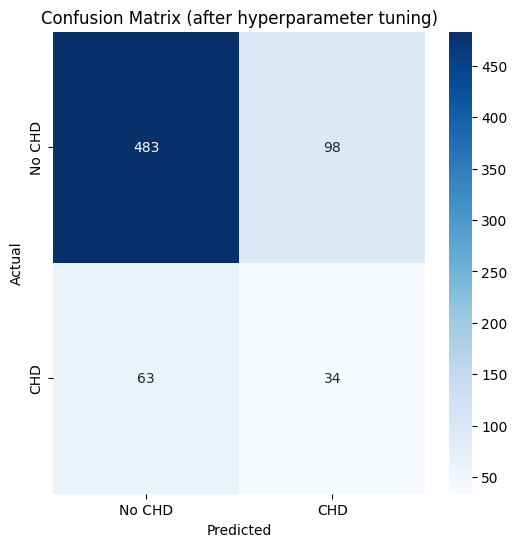

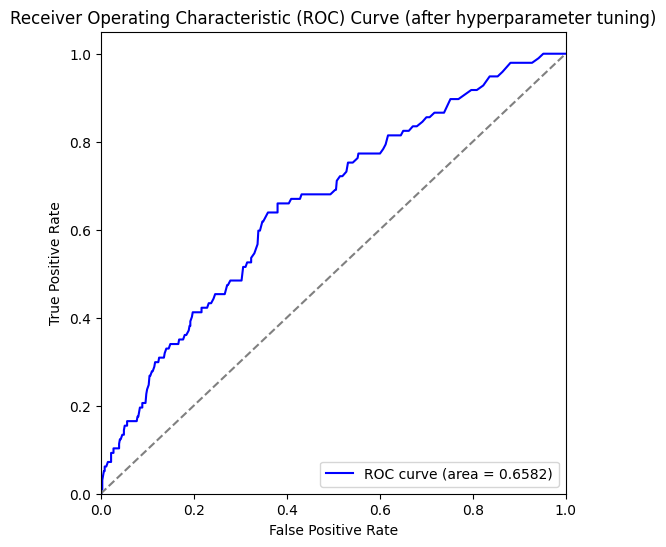


AUC Score (after hyperparameter tuning): 0.6582


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with class_weight='balanced' to handle class imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid for tuning hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for splitting a node
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")

# Train the Random Forest with the best parameters
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred_rf_best = best_rf.predict(X_test)

# Calculate the accuracy
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Accuracy after hyperparameter tuning: {accuracy_rf_best:.4f}")

# Classification Report
print("\nClassification Report (after hyperparameter tuning):")
print(classification_report(y_test, y_pred_rf_best))

# Confusion Matrix
print("\nConfusion Matrix (after hyperparameter tuning):")
conf_matrix_rf_best = confusion_matrix(y_test, y_pred_rf_best)
print(conf_matrix_rf_best)

# Plotting confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf_best, annot=True, fmt="d", cmap="Blues", xticklabels=["No CHD", "CHD"], yticklabels=["No CHD", "CHD"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (after hyperparameter tuning)')
plt.show()

# ROC Curve and AUC
fpr_rf_best, tpr_rf_best, thresholds_rf_best = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
roc_auc_rf_best = auc(fpr_rf_best, tpr_rf_best)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf_best, tpr_rf_best, color='blue', label=f'ROC curve (area = {roc_auc_rf_best:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (after hyperparameter tuning)')
plt.legend(loc="lower right")
plt.show()

# AUC Score
print(f"\nAUC Score (after hyperparameter tuning): {roc_auc_rf_best:.4f}")


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# Fit and transform the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Split the resampled data into train and validation sets (keeping test data unchanged)
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Now you can train the model using the resampled training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_resampled = rf.predict(X_val_resampled)

# Display performance metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_resampled = accuracy_score(y_val_resampled, y_pred_resampled)
print(f"Accuracy after oversampling (SMOTE): {accuracy_resampled}")

print("Classification Report (after SMOTE):")
print(classification_report(y_val_resampled, y_pred_resampled))

print("Confusion Matrix (after SMOTE):")
print(confusion_matrix(y_val_resampled, y_pred_resampled))


Accuracy after oversampling (SMOTE): 0.841304347826087
Classification Report (after SMOTE):
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       479
           1       0.80      0.89      0.84       441

    accuracy                           0.84       920
   macro avg       0.84      0.84      0.84       920
weighted avg       0.85      0.84      0.84       920

Confusion Matrix (after SMOTE):
[[381  98]
 [ 48 393]]


In [ ]:
# Check the number of features in the resampled training data
print(f"Number of features in the resampled training data: {X_train_resampled.shape[1]}")


Number of features in the resampled training data: 16


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Train the model using the resampled training data
log_reg.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_log_reg = log_reg.predict(X_val_resampled)

# Display performance metrics
accuracy_log_reg = accuracy_score(y_val_resampled, y_pred_log_reg)
print(f"Accuracy after oversampling (SMOTE) - Logistic Regression: {accuracy_log_reg}")
print("Classification Report (Logistic Regression after SMOTE):")
print(classification_report(y_val_resampled, y_pred_log_reg))
print("Confusion Matrix (Logistic Regression after SMOTE):")
print(confusion_matrix(y_val_resampled, y_pred_log_reg))


Accuracy after oversampling (SMOTE) - Logistic Regression: 0.6978260869565217
Classification Report (Logistic Regression after SMOTE):
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       479
           1       0.68      0.71      0.69       441

    accuracy                           0.70       920
   macro avg       0.70      0.70      0.70       920
weighted avg       0.70      0.70      0.70       920

Confusion Matrix (Logistic Regression after SMOTE):
[[330 149]
 [129 312]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.svm import SVC

# Initialize the Support Vector Classifier
svm = SVC(random_state=42)

# Train the model using the resampled training data
svm.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_svm = svm.predict(X_val_resampled)

# Display performance metrics
accuracy_svm = accuracy_score(y_val_resampled, y_pred_svm)
print(f"Accuracy after oversampling (SMOTE) - SVM: {accuracy_svm}")
print("Classification Report (SVM after SMOTE):")
print(classification_report(y_val_resampled, y_pred_svm))
print("Confusion Matrix (SVM after SMOTE):")
print(confusion_matrix(y_val_resampled, y_pred_svm))


Accuracy after oversampling (SMOTE) - SVM: 0.6358695652173914
Classification Report (SVM after SMOTE):
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       479
           1       0.61      0.66      0.63       441

    accuracy                           0.64       920
   macro avg       0.64      0.64      0.64       920
weighted avg       0.64      0.64      0.64       920

Confusion Matrix (SVM after SMOTE):
[[295 184]
 [151 290]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the K-Nearest Neighbors model
knn = KNeighborsClassifier()

# Train the model using the resampled training data
knn.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_knn = knn.predict(X_val_resampled)

# Display performance metrics
accuracy_knn = accuracy_score(y_val_resampled, y_pred_knn)
print(f"Accuracy after oversampling (SMOTE) - KNN: {accuracy_knn}")
print("Classification Report (KNN after SMOTE):")
print(classification_report(y_val_resampled, y_pred_knn))
print("Confusion Matrix (KNN after SMOTE):")
print(confusion_matrix(y_val_resampled, y_pred_knn))


Accuracy after oversampling (SMOTE) - KNN: 0.7554347826086957
Classification Report (KNN after SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.61      0.72       479
           1       0.68      0.91      0.78       441

    accuracy                           0.76       920
   macro avg       0.78      0.76      0.75       920
weighted avg       0.79      0.76      0.75       920

Confusion Matrix (KNN after SMOTE):
[[292 187]
 [ 38 403]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Train the model using the resampled training data
gb.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_gb = gb.predict(X_val_resampled)

# Display performance metrics
accuracy_gb = accuracy_score(y_val_resampled, y_pred_gb)
print(f"Accuracy after oversampling (SMOTE) - Gradient Boosting: {accuracy_gb}")
print("Classification Report (Gradient Boosting after SMOTE):")
print(classification_report(y_val_resampled, y_pred_gb))
print("Confusion Matrix (Gradient Boosting after SMOTE):")
print(confusion_matrix(y_val_resampled, y_pred_gb))


Accuracy after oversampling (SMOTE) - Gradient Boosting: 0.7489130434782608
Classification Report (Gradient Boosting after SMOTE):
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       479
           1       0.72      0.78      0.75       441

    accuracy                           0.75       920
   macro avg       0.75      0.75      0.75       920
weighted avg       0.75      0.75      0.75       920

Confusion Matrix (Gradient Boosting after SMOTE):
[[344 135]
 [ 96 345]]


In [ ]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)

# Train the model using the resampled training data
xgb.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_xgb = xgb.predict(X_val_resampled)

# Display performance metrics
accuracy_xgb = accuracy_score(y_val_resampled, y_pred_xgb)
print(f"Accuracy after oversampling (SMOTE) - XGBoost: {accuracy_xgb}")
print("Classification Report (XGBoost after SMOTE):")
print(classification_report(y_val_resampled, y_pred_xgb))
print("Confusion Matrix (XGBoost after SMOTE):")
print(confusion_matrix(y_val_resampled, y_pred_xgb))


Accuracy after oversampling (SMOTE) - XGBoost: 0.8260869565217391
Classification Report (XGBoost after SMOTE):
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       479
           1       0.78      0.88      0.83       441

    accuracy                           0.83       920
   macro avg       0.83      0.83      0.83       920
weighted avg       0.83      0.83      0.83       920

Confusion Matrix (XGBoost after SMOTE):
[[373 106]
 [ 54 387]]


In [ ]:
import pickle

# Save the model to a file
with open('random_forest_model_smote.pkl', 'wb') as file:
    pickle.dump(rf, file)


In [ ]:
# Load the model
loaded_model = joblib.load('random_forest_model_smote.pkl')

# Make predictions with the loaded model
y_pred_loaded_model = loaded_model.predict(X_val_resampled)

# Evaluate the model
accuracy_loaded_model = accuracy_score(y_val_resampled, y_pred_loaded_model)
print(f"Accuracy of the loaded model: {accuracy_loaded_model}")


Accuracy of the loaded model: 0.841304347826087


In [ ]:
df.head()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Cluster,sex_1,is_smoking_1
0,0,64,1,1,1,0,0,0,1,148.0,85.0,1,1,1,1,0,False,True
1,1,36,1,1,1,0,1,0,1,168.0,98.0,1,1,1,0,2,True,False
2,2,46,1,1,1,0,0,0,1,116.0,71.0,1,1,1,0,0,False,True
3,3,50,1,1,1,0,1,0,1,158.0,88.0,1,1,1,1,2,True,True
4,4,64,1,1,1,0,0,0,1,136.5,85.0,1,1,1,0,0,False,True


In [ ]:
# Extract feature importances
feature_importances = rf.feature_importances_

# Get the feature names (if available, otherwise use indices)
feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])

# Create a DataFrame to display the feature importances
import pandas as pd

# Combine feature names and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the important features
print(feature_importance_df)


            Feature  Importance
8             sysBP    0.305315
9             diaBP    0.259084
0               age    0.233279
14            sex_1    0.088346
15     is_smoking_1    0.052213
13          Cluster    0.040028
5      prevalentHyp    0.013474
6          diabetes    0.006896
4   prevalentStroke    0.001366
1         education    0.000000
2        cigsPerDay    0.000000
3            BPMeds    0.000000
7           totChol    0.000000
10              BMI    0.000000
11        heartRate    0.000000
12          glucose    0.000000


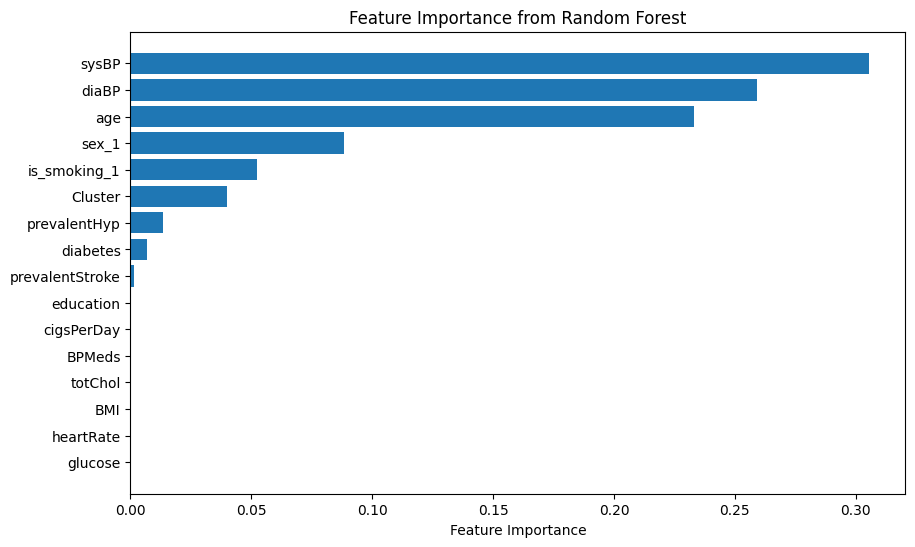

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


In [ ]:
# Extract feature importances
feature_importances = rf.feature_importances_

# Get the feature names (if available, otherwise use indices)
feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])

# Create a DataFrame to display the feature importances
import pandas as pd

# Combine feature names and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save the DataFrame to a CSV file
feature_importance_df.to_csv('feature_importances.csv', index=False)

# Optional: Confirm that the file is saved
print("Feature importances have been saved to 'feature_importances.csv'.")


Feature importances have been saved to 'feature_importances.csv'.


In [ ]:
import pandas as pd

# Load the CSV file containing feature importances
feature_importance_df = pd.read_csv('feature_importances.csv')

# Display the top important features
print(feature_importance_df.head())


        Feature  Importance
0         sysBP    0.305315
1         diaBP    0.259084
2           age    0.233279
3         sex_1    0.088346
4  is_smoking_1    0.052213


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       581
           1       0.27      0.40      0.32        97

    accuracy                           0.76       678
   macro avg       0.58      0.61      0.59       678
weighted avg       0.80      0.76      0.78       678

Confusion Matrix:
[[474 107]
 [ 58  39]]
AUC Score: 0.6452614582039498


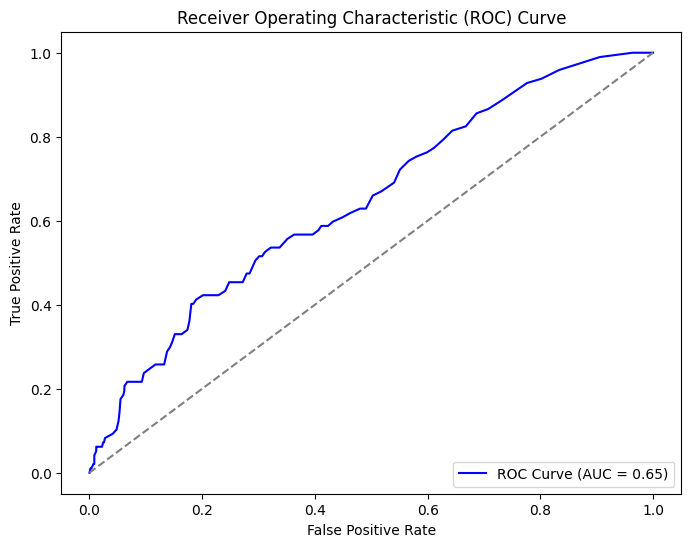

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predictions after SMOTE
y_pred = rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred)

# AUC score
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability of the positive class
roc_auc = roc_auc_score(y_test, y_prob)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_value = auc(fpr, tpr)

# Print the evaluation metrics
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{cm}")
print(f"AUC Score: {roc_auc}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Save the trained Random Forest model explicitly
joblib.dump(rf, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [ ]:
# Save the trained Random Forest model explicitly
joblib.dump(rf, 'random_forest_model.pkl')

# Load the saved Random Forest model
loaded_model = joblib.load('random_forest_model.pkl')

# Predict using the loaded model
y_pred_loaded = loaded_model.predict(X_test)  # Ensure X_test is preprocessed correctly

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy after loading the model: {accuracy:.4f}")


Accuracy after loading the model: 0.8466


In [ ]:
print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of features in RandomForest model: {len(rf.feature_importances_)}")


Number of features in X_train: 16
Number of features in RandomForest model: 16


In [ ]:
# Assuming X_train has 16 features
feature_names = ['age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp',
                 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose',
                 'TenYearCHD', 'Cluster', 'sex_1']


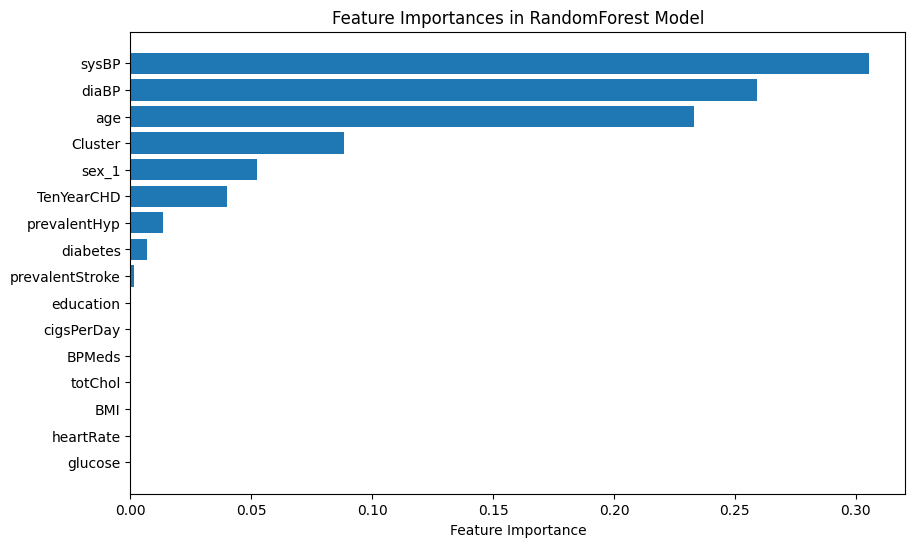

            Feature  Importance
8             sysBP    0.305315
9             diaBP    0.259084
0               age    0.233279
14          Cluster    0.088346
15            sex_1    0.052213
13       TenYearCHD    0.040028
5      prevalentHyp    0.013474
6          diabetes    0.006896
4   prevalentStroke    0.001366
1         education    0.000000
2        cigsPerDay    0.000000
3            BPMeds    0.000000
7           totChol    0.000000
10              BMI    0.000000
11        heartRate    0.000000
12          glucose    0.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the feature importances from the trained RandomForest model
importances = rf.feature_importances_

# Creating a DataFrame to display the importance of each feature
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances in RandomForest Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

# Display the DataFrame with feature importances
print(feature_importance_df)
